# Example of Metric Learning in Embedded Space

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

sys.path.append('..')
device = "cuda" if torch.cuda.is_available() else "cpu"

## Pytorch Lightning Model

In this example notebook, we will use an approach to ML called Pytorch Lightning. Pytorch is a library like Tensorflow, which is very popular in ML engineering. It's main appeal is foolproof tracking of gradients for backpropagation, and very easy manipulation of tensors on and off GPUs. 

Pytorch Lightning is an extension of Pytorch that makes some decisions about the best-practices for training. Instead of you writing the training loop yourself, and moving things on and off a GPU, it handles much of this for you. You write all the data loading logic, the loss functions, etc. into a `LightningModule` and then hand this module to a `Trainer`. Together, the module and trainer are the two objects that allow training and inference. 

So we start by importing a class that we have written ourselves, in this case a LightningModule that is in charge of loading TrackML (Codalab) data, and training and validating an embedding/metric learning model. 

In [3]:
import sys
import os
import logging

# 3rd party imports
import pytorch_lightning as pl
from pytorch_lightning import LightningModule
import torch
from torch.nn import Linear
import torch.nn as nn
from torch_geometric.data import DataLoader
from torch_cluster import radius_graph
import numpy as np

# Local Imports
from LightningModules.Embedding.utils import graph_intersection, split_datasets, build_edges

device = "cuda" if torch.cuda.is_available() else "cpu"


class EmbeddingBase(LightningModule):
    def __init__(self, hparams):
        super().__init__()
        """
        Initialise the Lightning Module that can scan over different embedding training regimes
        """
        self.save_hyperparameters(hparams)

    def setup(self, stage):
        if stage == "fit":
            self.trainset, self.valset, self.testset = split_datasets(
                self.hparams["input_dir"],
                self.hparams["train_split"],
                self.hparams["pt_min"],
            )

    def train_dataloader(self):
        if len(self.trainset) > 0:
            return DataLoader(self.trainset, batch_size=1, num_workers=1)
        else:
            return None

    def val_dataloader(self):
        if len(self.valset) > 0:
            return DataLoader(self.valset, batch_size=1, num_workers=1)
        else:
            return None

    def test_dataloader(self):
        if len(self.testset):
            return DataLoader(self.testset, batch_size=1, num_workers=1)
        else:
            return None

    def configure_optimizers(self):
        optimizer = [
            torch.optim.AdamW(
                self.parameters(),
                lr=(self.hparams["lr"]),
                betas=(0.9, 0.999),
                eps=1e-08,
                amsgrad=True,
            )
        ]
        #         scheduler = [
        #             {
        #                 'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer[0], factor=self.hparams["factor"], patience=self.hparams["patience"]),
        #                 'monitor': 'val_loss',
        #                 'interval': 'epoch',
        #                 'frequency': 1
        #             }
        #         ]
        scheduler = [
            {
                "scheduler": torch.optim.lr_scheduler.StepLR(
                    optimizer[0],
                    step_size=self.hparams["patience"],
                    gamma=self.hparams["factor"],
                ),
                "interval": "epoch",
                "frequency": 1,
            }
        ]
        #         scheduler = [torch.optim.lr_scheduler.StepLR(optimizer[0], step_size=1, gamma=0.3)]
        return optimizer, scheduler

    def training_step(self, batch, batch_idx):

        """
        Args:
            batch (``list``, required): A list of ``torch.tensor`` objects
            batch (``int``, required): The index of the batch

        Returns:
            ``torch.tensor`` The loss function as a tensor
        """

        # Forward pass of model, handling whether Cell Information (ci) is included
        if "ci" in self.hparams["regime"]:
            spatial = self(torch.cat([batch.cell_data[:, :self.hparams["cell_channels"]], batch.x], axis=-1))
        else:
            spatial = self(batch.x)
            
#         cut_indices = batch.modulewise_true_edges.unique()
        cut_indices = torch.arange(len(spatial), device=self.device)
        query = spatial[cut_indices]

        # Instantiate bidirectional truth (since KNN prediction will be bidirectional)
        e_bidir = torch.cat(
            [batch.modulewise_true_edges, batch.modulewise_true_edges.flip(0)], axis=-1
        )

        # Instantiate empty prediction edge list
        e_spatial = torch.empty([2, 0], dtype=torch.int64, device=self.device)

        # Append random edges pairs (rp) for stability
        if "rp" in self.hparams["regime"]:
            
            n_random = int(self.hparams["randomisation"] * len(cut_indices))
            indices_src = torch.randint(0, len(cut_indices), (n_random,), device=self.device)
            indices_dest = torch.randint(0, len(spatial), (n_random,), device=self.device)
            random_pairs = torch.stack([cut_indices[indices_src], indices_dest])
            
            
            e_spatial = torch.cat(
                [
                    e_spatial,
                    random_pairs
                ],
                axis=-1,
            )

        # Append Hard Negative Mining (hnm) with KNN graph
        if "hnm" in self.hparams["regime"]:
            e_spatial = torch.cat(
                [
                    e_spatial,
                    build_edges(query, spatial, cut_indices, self.hparams["r_train"], self.hparams["knn"]),
                ],
                axis=-1,
            )

        # Calculate truth from intersection between Prediction graph and Truth graph
        e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)
        new_weights = y_cluster.to(self.device) * self.hparams["weight"]

        # Append all positive examples and their truth and weighting
        e_spatial = torch.cat(
            [
                e_spatial.to(self.device),
                e_bidir,
            ],
            axis=-1,
        )
        y_cluster = torch.cat([y_cluster.int(), torch.ones(e_bidir.shape[1])])
        new_weights = torch.cat(
            [
                new_weights,
                torch.ones(e_bidir.shape[1], device=self.device)
                * self.hparams["weight"],
            ]
        )

        hinge = y_cluster.float().to(self.device)
        hinge[hinge == 0] = -1

        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors) ** 2, dim=-1)

        new_weights[
            y_cluster == 0
        ] = 1  # Give negative examples a weight of 1 (note that there may still be TRUE examples that are weightless)
        d = d * new_weights

        loss = torch.nn.functional.hinge_embedding_loss(
            d, hinge, margin=self.hparams["margin"], reduction="mean"
        )

        self.log("train_loss", loss)

        return loss

    def shared_evaluation(self, batch, batch_idx, knn_radius, knn_num, log=False):

        if "ci" in self.hparams["regime"]:
            spatial = self(torch.cat([batch.cell_data[:, :self.hparams["cell_channels"]], batch.x], axis=-1))
        else:
            spatial = self(batch.x)

        e_bidir = torch.cat(
            [batch.modulewise_true_edges, batch.modulewise_true_edges.flip(0)], axis=-1
        )

        # Build whole KNN graph
        e_spatial = build_edges(spatial, spatial, indices=None, r_max=knn_radius, k_max=knn_num)

        e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)
        new_weights = y_cluster.to(self.device) * self.hparams["weight"]

        hinge = y_cluster.float().to(self.device)
        hinge[hinge == 0] = -1

        e_spatial = e_spatial.to(self.device)
        reference = spatial.index_select(0, e_spatial[1])
        neighbors = spatial.index_select(0, e_spatial[0])
        d = torch.sum((reference - neighbors) ** 2, dim=-1)

        new_weights[y_cluster == -1] = 1
        d = d # * new_weights THIS IS BETTER TO NOT INCLUDE

        loss = torch.nn.functional.hinge_embedding_loss(
            d, hinge, margin=self.hparams["margin"], reduction="mean"
        )

        cluster_true = e_bidir.shape[1]
        cluster_true_positive = y_cluster.sum()
        cluster_positive = len(e_spatial[0])

        eff = torch.tensor(cluster_true_positive / cluster_true)
        pur = torch.tensor(cluster_true_positive / cluster_positive)

        current_lr = self.optimizers().param_groups[0]["lr"]
        if log:
            self.log_dict(
                {"val_loss": loss, "eff": eff, "pur": pur, "current_lr": current_lr}
            )
        logging.info("Efficiency: {}".format(eff))
        logging.info("Purity: {}".format(pur))
        logging.info(batch.event_file)

        return {
            "loss": loss,
            "preds": e_spatial.cpu().numpy(),
            "truth": y_cluster.cpu().numpy(),
            "truth_graph": e_bidir.cpu().numpy(),
        }

    def validation_step(self, batch, batch_idx):
        """
        Step to evaluate the model's performance
        """

        outputs = self.shared_evaluation(
            batch, batch_idx, self.hparams["r_val"], 300, log=True
        )

        return outputs["loss"]

    def test_step(self, batch, batch_idx):
        """
        Step to evaluate the model's performance
        """
        outputs = self.shared_evaluation(
            batch, batch_idx, self.hparams["r_test"], 500, log=True
        )

        return outputs

    def optimizer_step(
        self,
        epoch,
        batch_idx,
        optimizer,
        optimizer_idx,
        optimizer_closure=None,
        on_tpu=False,
        using_native_amp=False,
        using_lbfgs=False,
    ):
        """
        Use this to manually enforce warm-up. In the future, this may become built-into PyLightning
        """

        # warm up lr
        if (self.hparams["warmup"] is not None) and (
            self.trainer.global_step < self.hparams["warmup"]
        ):
            lr_scale = min(
                1.0, float(self.trainer.global_step + 1) / self.hparams["warmup"]
            )
            for pg in optimizer.param_groups:
                pg["lr"] = lr_scale * self.hparams["lr"]

        # update params
        optimizer.step(closure=optimizer_closure)
        optimizer.zero_grad()

class LayerlessEmbedding(EmbeddingBase):
    def __init__(self, hparams):
        super().__init__(hparams)
        """
        Initialise the Lightning Module that can scan over different embedding training regimes
        """

          # Construct the MLP architecture
        if "ci" in hparams["regime"]:
            in_channels = hparams["spatial_channels"] + hparams["cell_channels"]
        else:
            in_channels = hparams["spatial_channels"]
        layers = [Linear(in_channels, hparams["emb_hidden"])]
        ln = [
            Linear(hparams["emb_hidden"], hparams["emb_hidden"])
            for _ in range(hparams["nb_layer"] - 1)
        ]

        layers.extend(ln)
        self.layers = nn.ModuleList(layers)
        self.emb_layer = nn.Linear(hparams["emb_hidden"], hparams["emb_dim"])
        self.norm = nn.LayerNorm(hparams["emb_hidden"])
        self.act = nn.Tanh()
        self.save_hyperparameters()

    def forward(self, x):
        #         hits = self.normalize(hits)
        for l in self.layers:
            x = l(x)
            x = self.act(x)
        #         x = self.norm(x) #Option of LayerNorm
        x = self.emb_layer(x)
        return x

### Construct PyLightning model

An ML model typically has many knobs to turn, as well as locations of data, some training preferences, and so on. For convenience, let's put all of these parameters into a YAML file and load it.

In [4]:
with open("example_embedding.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)

We plug these parameters into a constructor of the `LayerlessEmbedding` Lightning Module. This doesn't **do** anything yet - merely creates the object.

In [5]:
model = LayerlessEmbedding(hparams)

## The Dataset

To load the data, we call a `setup` method. There is some flexibility in how to handle data, and one should check the Pytorch Lightning docs to see the spectrum of options. This is my favourite way: Hide all of the data loading inside the Lightning module. We are explicitly calling `setup` here because we're going to visualise some of the data first. In future, once you know the nature of the data, we can skip this step, since the trainer will call this automatically when it starts training. 

NOTE: This may take a minute or two, since the data is being trimmed to particles above a certain momentum threshold.

In [6]:
model.setup(stage="fit")

### Visualise geometry

Just as a sanity check, let's look directly at the geometry of the data, as well as some distributions. This is just to make sure that, e.g. it's normalised in some reasonable way (that is, it doesn't vary from -1000 to +1000 or some large numbers, but that it is distributed close to +1 and -1 - this makes training much more effective!), and there aren't weird outliers (this also damages training!). 

In [7]:
trainset = model.trainset

In [8]:
example_data = trainset[0]
r, phi, z = example_data.x.T

In [13]:
x, y = r*np.cos(phi*np.pi)*1000, r*np.sin(phi*np.pi)*1000
z = z*1000

(Text(0.5, 1.0, 'Down-beampipe Spacepoint Distribution'),
 Text(0.5, 0, 'x direction (mm)'),
 Text(0, 0.5, 'y direction (mm)'))

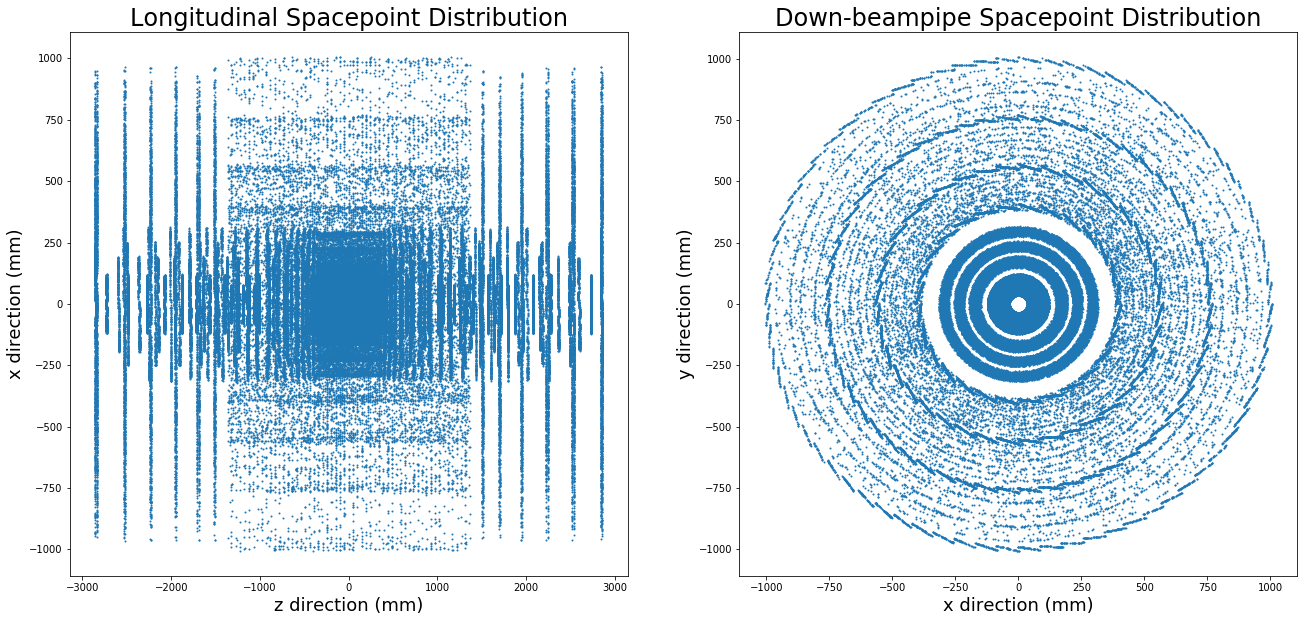

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(22,10))
axs[0].scatter(z, x, s=1)
axs[1].scatter(x, y, s=1)
axs[0].set_title("Longitudinal Spacepoint Distribution", fontsize=24), axs[0].set_xlabel("z direction (mm)", fontsize=18), axs[0].set_ylabel("x direction (mm)", fontsize=18)
axs[1].set_title("Down-beampipe Spacepoint Distribution", fontsize=24), axs[1].set_xlabel("x direction (mm)", fontsize=18), axs[1].set_ylabel("y direction (mm)", fontsize=18)

### Visualise distributions

(Text(0.5, 1.0, 'Distribution of Momentum'),
 Text(0.5, 0, 'pT (GeV)'),
 Text(0, 0.5, 'Count'))

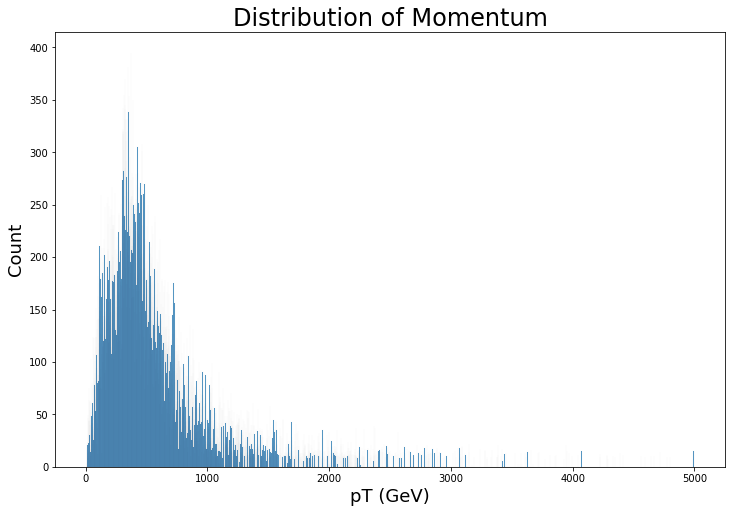

In [47]:
plt.figure(figsize=(12,8))
sns.histplot(example_data.pt[example_data.pt == example_data.pt], binwidth=200, binrange=[0, 5000])
plt.title("Distribution of Momentum", fontsize=24), plt.xlabel("pT (GeV)", fontsize=18), plt.ylabel("Count", fontsize=18)

(Text(0.5, 1.0, 'Distribution of Momentum'),
 Text(0.5, 0, 'pT (GeV)'),
 Text(0, 0.5, 'Count'))

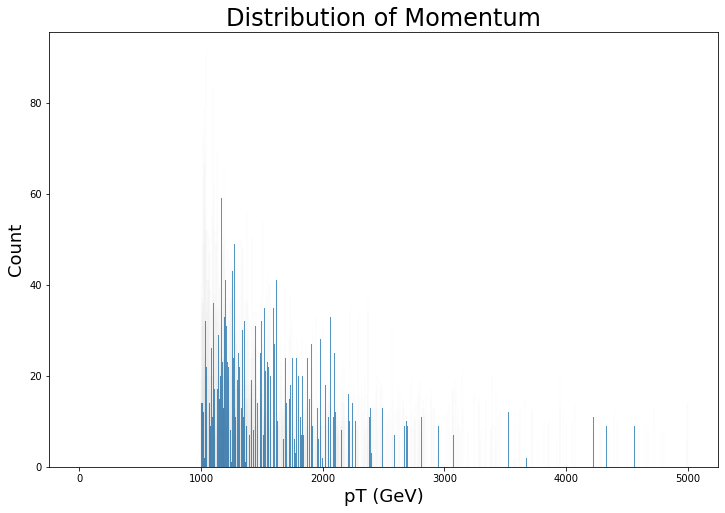

In [49]:
plt.figure(figsize=(12,8))
sns.histplot(example_data.pt[example_data.modulewise_true_edges[0]], binrange=[0, 5000])
plt.title("Distribution of Momentum", fontsize=24), plt.xlabel("pT (GeV)", fontsize=18), plt.ylabel("Count", fontsize=18)

Observe the hard cut-off below 1GeV - this is because we are ignoring lower energy hits to keep things easy for now. But we should include them again once we are happy with our ML architecture!

In [20]:
particle_num, particle_counts = np.unique(example_data.pid.numpy(), return_counts = True)

(Text(0.5, 1.0, 'Distribution of Hits per Particle'),
 Text(0.5, 0, 'Hits'),
 Text(0, 0.5, 'Count'))

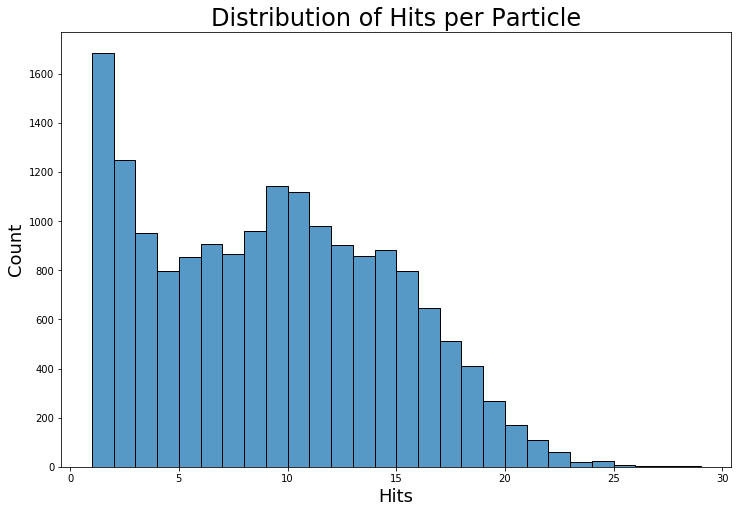

In [22]:
plt.figure(figsize=(12,8))
sns.histplot(particle_counts[:-1], binwidth=1)
plt.title("Distribution of Hits per Particle", fontsize=24), plt.xlabel("Hits", fontsize=18), plt.ylabel("Count", fontsize=18)

This gives an idea about how long each particle track is. We can see that most particle tracks leave > 10 hits, which will be useful for our graph neural networks down the track. In general, shorter tracks are harder to detect, and less useful for doing meaningful physics.

### Cell Info

In [20]:
cell_features = [
            "norm_x",
            "norm_y",
            "barrel_endcap",
            "layer_disk",
            "eta_module",
            "phi_module",
            "eta_angle_1",
            "phi_angle_1",
            "eta_angle_2",
            "phi_angle_2",
            "pixel"
        ]

In [21]:
example_data.cell_data

tensor([[ 0.3610,  0.1495,  0.0000,  ..., -1.0000, -1.0000,  1.0000],
        [ 0.0000,  0.0000, -2.0000,  ..., -1.0000, -1.0000,  1.0000],
        [ 0.0000,  0.0000,  2.0000,  ..., -1.0000, -1.0000,  1.0000],
        ...,
        [ 0.0000,  0.0000,  2.0000,  ...,  1.3239,  0.0059,  0.0000],
        [ 0.0000,  0.0000,  2.0000,  ...,  0.5373,  0.0064,  0.0000],
        [ 0.0000,  0.0000,  2.0000,  ...,  1.3246,  0.0064,  0.0000]])

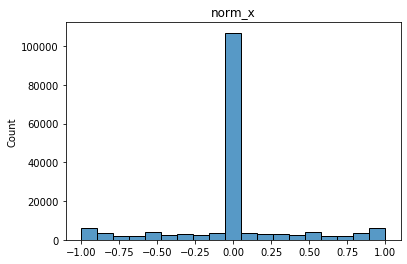

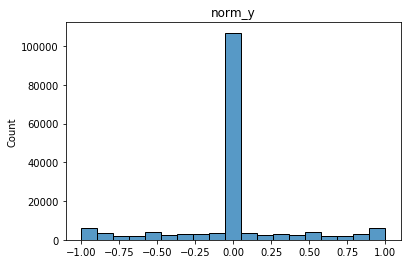

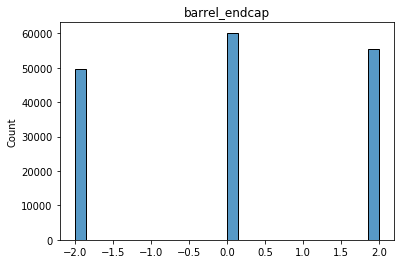

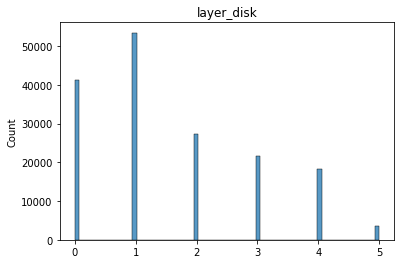

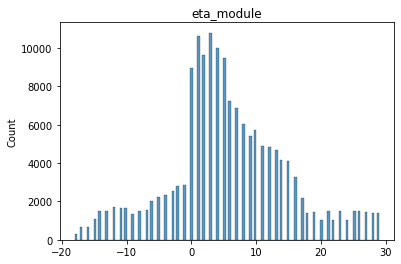

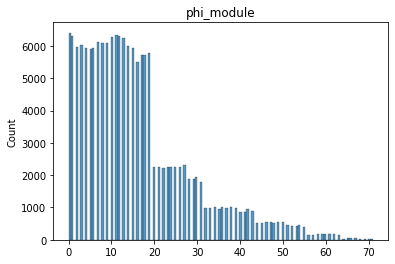

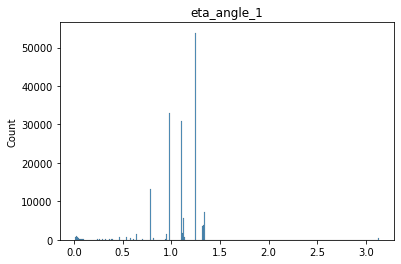

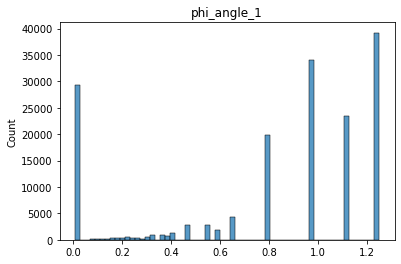

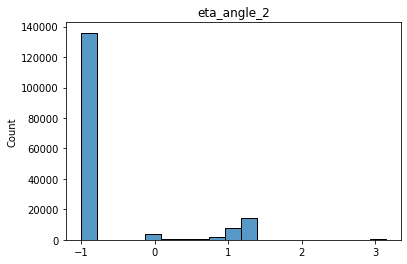

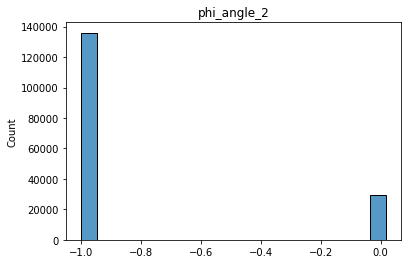

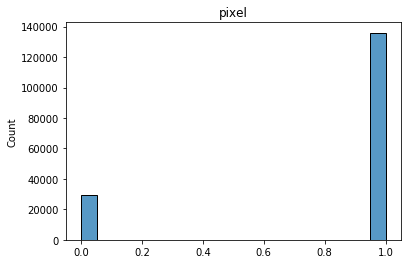

In [22]:
for i, feature in enumerate(cell_features):
    plt.figure()
    sns.histplot(example_data.cell_data[:, i].numpy()).set_title(feature)

## Metric Learning

In [6]:
from pytorch_lightning import Trainer

### Train embedding

Finally! Let's train! We instantiate a `Trainer` class that knows things like which hardware to work with, how long to train for, and a **bunch** of default options that we ignore here. Check out the Trainer class docs in Pytorch Lightning. Suffice it to say that it clears away much repetitive boilerplate in training code.

In [7]:
from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    filename='sample-mnist-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    save_last=True,
    mode='min',
)

In [8]:
logger = WandbLogger(project="ITk_1GeV", group="InitialTest")
trainer = Trainer(gpus=1, max_epochs=30, logger=logger)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.11.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Set SLURM handle signals.

  | Name      | Type       | Params
-----------------------------------------
0 | layers    | ModuleList | 5.3 M 
1 | emb_layer | Linear     | 8.2 K 
2 | norm      | LayerNorm  | 2.0 K 
3 | act       | Tanh       | 0     
-----------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params
21.082    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/ipykernel_launcher.py:220: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/ipykernel_launcher.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), ra

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  "Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2"


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Test embedding

A Pytorch Lightning Trainer has two main methods: `fit` and `test`. They represent the two main steps of any ML engingeering or research: Train a model, then make sure it can infer accurately on test (i.e. **hidden**) data.

Note that `ckpt_path` just tells the trainer to use the latest "checkpoint" of the model, rather than *best* checkpoint. A checkpoint is a saved version of the model, a snapshot at a particular stage of the training process. Pytorch Lightning automatically saves a checkpoint of your model in case something crashes and we need to resume.

In [12]:
model.hparams["r_test"] = 1.56

In [13]:
test_results = trainer.test(ckpt_path=None)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.local/lib/python3.7/site-packages/ipykernel_launcher.py:220: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/global/homes/d/danieltm/.local/lib/python3.7/site-packages/ipykernel_launcher.py:221: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 8.999999408842996e-05,
 'eff': 0.9704177975654602,
 'pur': 0.01038623321801424,
 'val_loss': 0.0745108500123024}
--------------------------------------------------------------------------------


## Performance

In [13]:
from LightningModules.Embedding.utils import get_metrics

Let's see how well the model learned to embed the hits into a space that separates them into discrete clusters. As in the data visualisation above, we are going manual here. So one thing we need to do is tell the model that we are **evaluating**, not **training**, with `model.eval()`. We also make sure to wrap everything with `with torch.no_grad()` to ignore any gradients. This speeds things up and gives the GPU's memory a rest, since we're not interesting in any kind of training from here on in.

In [24]:
model.eval();

### Test metrics

In [27]:
all_efficiencies, all_purities = [], []
all_radius = np.arange(0.5, 1.2, 0.1)

with torch.no_grad():
    for r in all_radius:

        model.hparams.r_test = r
        test_results = trainer.test(ckpt_path=None)[0]

        mean_efficiency, mean_purity = test_results["eff"], test_results["pur"]

        all_efficiencies.append(mean_efficiency)
        all_purities.append(mean_purity)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.29412952065467834,
 'pur': 0.31158846616744995,
 'val_loss': 0.8040090799331665}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.5026120543479919,
 'pur': 0.3214113712310791,
 'val_loss': 0.828713059425354}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.6482229828834534,
 'pur': 0.2828279137611389,
 'val_loss': 0.8727149963378906}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.745759904384613,
 'pur': 0.23499229550361633,
 'val_loss': 0.9117689728736877}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.8200681805610657,
 'pur': 0.18902744352817535,
 'val_loss': 0.9429423809051514}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.8717353343963623,
 'pur': 0.15006624162197113,
 'val_loss': 0.9644220471382141}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.9083821177482605,
 'pur': 0.12099817395210266,
 'val_loss': 0.9782997965812683}
--------------------------------------------------------------------------------


We should always visualise two important metrics: the efficiency (the number of true positives divided by the total number of possible true edges) and the purity (the number of true positives divided by the number of predicted edges). Is it clear to you why the graphs below behave as they do, as we widen the sphere around each hit to generate neighboring edges?

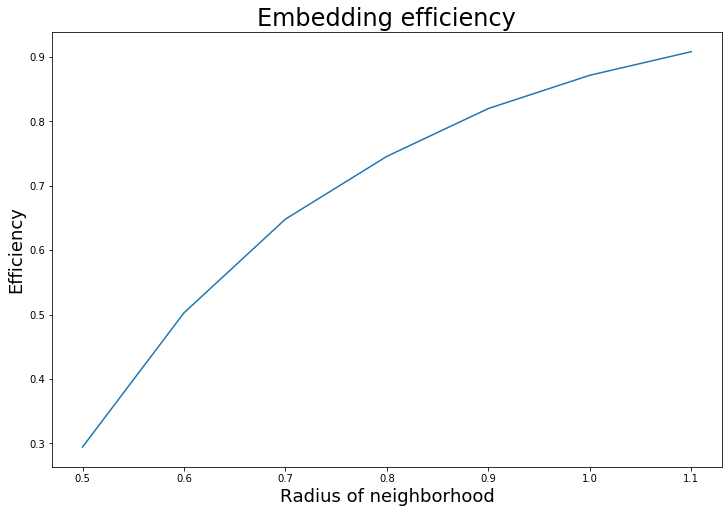

In [28]:
plt.figure(figsize=(12,8))
plt.plot(all_radius, all_efficiencies);
plt.title("Embedding efficiency", fontsize=24), plt.xlabel("Radius of neighborhood", fontsize=18), plt.ylabel("Efficiency", fontsize=18);

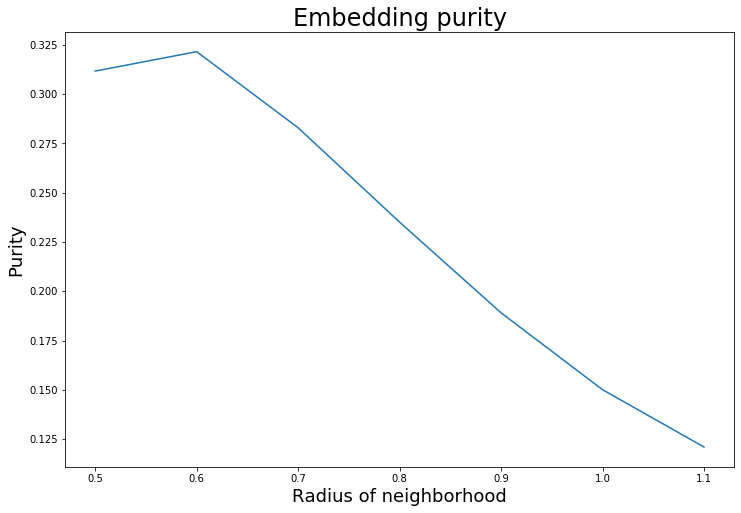

In [29]:
plt.figure(figsize=(12,8))
plt.plot(all_radius, all_purities);
plt.title("Embedding purity", fontsize=24), plt.xlabel("Radius of neighborhood", fontsize=18), plt.ylabel("Purity", fontsize=18);

### Visualise embedding / latent space

Another useful thing to visualise is the actual space being embedded into. Since it's 8 dimensional, we can reduce it to 2 dimensions with "Principal Component Analysis". 

In [24]:
from sklearn.decomposition import PCA

In [25]:
example_data = trainset[0]
particle_ids = example_data.pid
cyl_coords = example_data.x
cell_features = example_data.cell_data
all_features = torch.cat([cyl_coords, cell_features], axis=-1).to("cuda")

In [26]:
latent_features = model(all_features)

In [27]:
pca = PCA(n_components=2)

In [28]:
reduced_dimensions = pca.fit_transform(latent_features.detach().cpu())

In [29]:
reduced_dimensions

array([[-8.95513417, -3.68551328],
       [-9.26373197, -2.57803677],
       [17.49976278,  3.70361098],
       ...,
       [16.35837063, -5.6276739 ],
       [17.72111695, -4.57634675],
       [13.94139828, -8.52278351]])

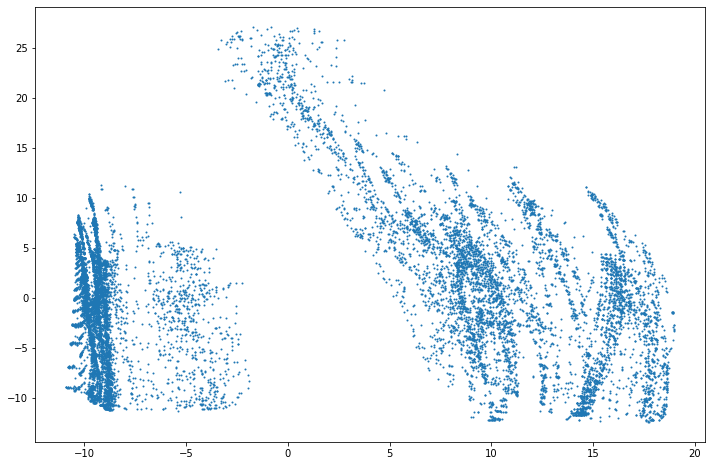

In [30]:
plt.figure(figsize=(12,8))
plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], s=1)

The above plot is what **all** the data looks like in the latent space. Let's pick a (long) particle track and see if the track is projected to be close together:

In [31]:
particles, counts = np.unique(example_data.pid, return_counts=True)

In [32]:
example_particle = particles[counts > 10][0]

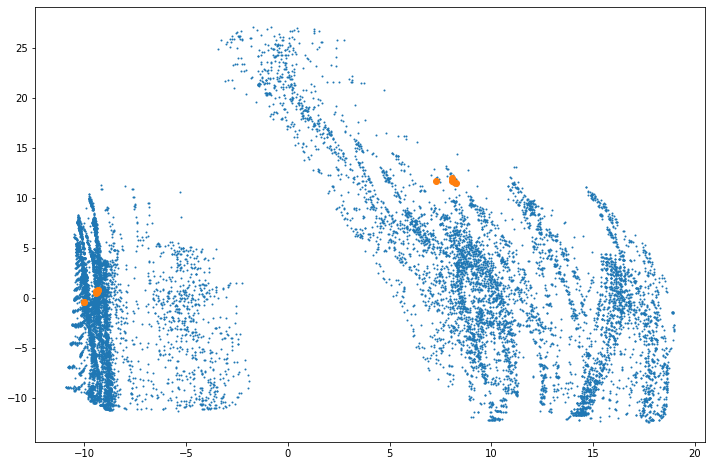

In [33]:
plt.figure(figsize=(12,8))
plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], s=1)
plt.scatter(reduced_dimensions[particle_ids == example_particle, 0], reduced_dimensions[particle_ids == example_particle, 1])

There are at least 10 hits in the plot above. Hopefully some of them cluster together into blobs, and that the blobs are close to other blobs of the same color. We get ~99% efficiency with this model, so even if some blobs appear far away in the PCA-reduced 2D space, they are most likely much closer in the 8-dimensional space. You can check this yourself!

## Further Investigation

1. Is there any performance gain from increasing the number of hidden channels?
2. What about *decreasing* the number of channels?
3. What about increasing/decreasing the number of dimensions in the latent space?
4. Is it possible to overtrain? That is, try increasing the number of epochs and seeing if the validation loss always decreases, plateaus, or starts to increase
5. Learning rate can be **everything** in some models. What effect does it have to increase/decrease it here?
6. Similarly, "warm-up" is like a slow start, where the learning rate increases for X batches (default of 100 here). Try changing it and seeing if you can improve the final performance.
7. To train the model here we use a combination of random pairs (that is, just picking pairs of hits at random, seeing if they belong to the same track, and 